First set of code getting to understand neural nets

I am designing neural net on MNIST handwritten digits images to identify their correct label i.e number in image.

You must have guessed its an image recognition task.

MNIST is called Hello world of Deep learning.

Lets start!!

This notebook is inspired from [Jeremy's][1] [Deep Learning][2] mooc and [Deep learning with python][3] book by Keras author [François Chollet][4] .


  [1]: https://www.linkedin.com/in/howardjeremy/
  [2]: http://course.fast.ai/
  [3]: https://www.manning.com/books/deep-learning-with-python
  [4]: https://research.google.com/pubs/105096.html

**Import all required libraries**
===============================

In [1]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
# from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

print("done till here")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

2024-12-17 22:39:58.031453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


done till here
deep-neural-network-keras-way.ipynb
digit-recognizer.zip
main_keras.py
myenv
sample_submission.csv
test.csv
train.csv



**Load Train and Test data**
============================

In [4]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test= pd.read_csv("test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [7]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

The output variable is an integer from 0 to 9. This is a **multiclass** classification problem.

## Data Visualization
Lets look at 3 images from data set with their labels.

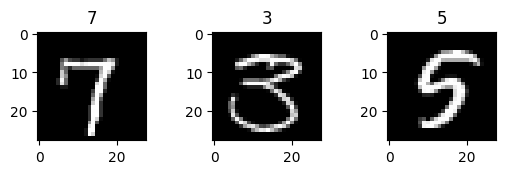

In [9]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [10]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [11]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

**Preprocessing the digit images**
==================================

**Feature Standardization**
-------------------------------------

It is important preprocessing step.
It is used to centre the data around zero mean and unit variance.

In [12]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

*One Hot encoding of labels.*
-----------------------------

A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension. 

For example, 3 would be [0,0,0,1,0,0,0,0,0,0].

In [13]:
from keras.utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

Lets plot 10th label.

/data/4wade/image_processing/myenv/lib/python3.8/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


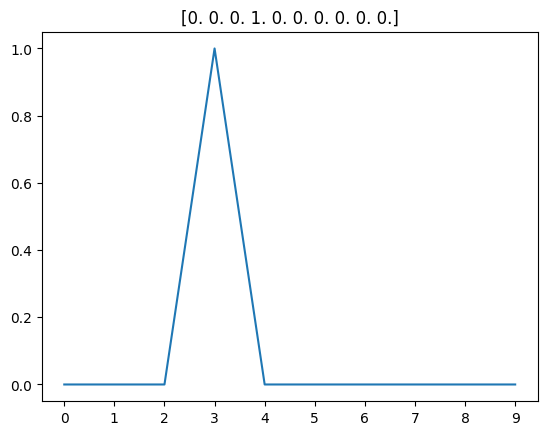

In [14]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

Oh its 3 !

**Designing Neural Network Architecture**
=========================================

In [15]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

*Linear Model*
--------------

In [16]:
from keras.models import  Sequential
from keras.layers import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

Lets create a simple model from Keras Sequential layer.

1. Lambda layer performs simple arithmetic operations like sum, average, exponentiation etc.

 In 1st layer of the model we have to define input dimensions of our data in (rows,columns,colour channel) format.
 (In theano colour channel comes first)


2. Flatten will transform input into 1D array.


3. Dense is fully connected layer that means all neurons in previous layers will be connected to all neurons in fully connected layer.
 In the last layer we have to specify output dimensions/classes of the model.
 Here it's 10, since we have to output 10 different digit labels.

In [17]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


2024-12-17 22:41:22.108740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1715 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5
2024-12-17 22:41:22.109464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 2657 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-12-17 22:41:22.110051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 2657 MB memory:  -> device: 2, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


***Compile network***
-------------------

Before making network ready for training we have to make sure to add below things:

 1.  A loss function: to measure how good the network is
    
 2.  An optimizer: to update network as it sees more data and reduce loss
    value
    
 3.  Metrics: to monitor performance of network

In [22]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [23]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

## Cross Validation 

In [24]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [25]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3


/tmp/ipykernel_1774267/2842184565.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3,


2024-12-17 22:43:02.441990: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7805457445248877322
2024-12-17 22:43:02.442086: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4904075985750017418


2024-12-17 22:43:03.516565: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 454118826869387689
2024-12-17 22:43:03.516653: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3695255949370422397


34020/34020 [==============================] - 9s 261us/step - loss: 0.3059 - accuracy: 0.9123 - val_loss: 0.2950 - val_accuracy: 0.9135


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

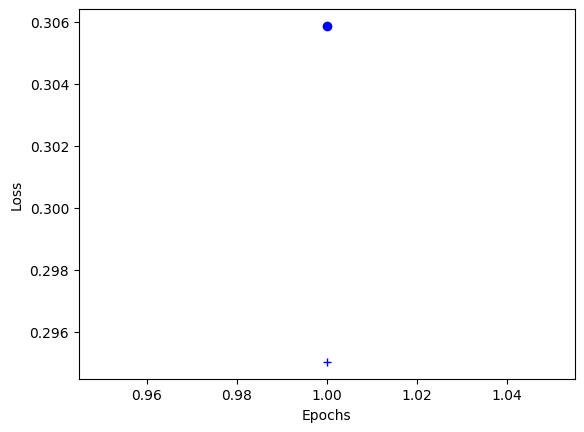

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

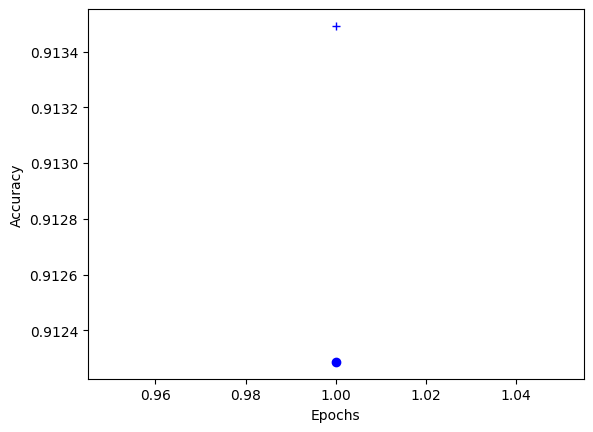

In [28]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

## Fully Connected Model

Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. 
Adding another Dense Layer to model.

In [29]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [31]:
fc = get_fc_model()
fc.optimizer.lr=0.01

In [33]:
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=5, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/5
    5/34020 [..............................] - ETA: 7:40 - loss: 0.2279 - accuracy: 0.9187 

/tmp/ipykernel_1774267/1154731458.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=5,


2024-12-17 22:46:11.385524: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5649944731424281246
2024-12-17 22:46:11.385590: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3695255949370422397
2024-12-17 22:46:11.385621: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12597889849155953985


2024-12-17 22:46:12.288535: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 7805457445248877322
2024-12-17 22:46:12.288601: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4904075985750017418
2024-12-17 22:46:12.288626: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 454118826869387689


34020/34020 [==============================] - 8s 233us/step - loss: 0.2100 - accuracy: 0.9409 - val_loss: 0.2322 - val_accuracy: 0.9394


## Convolutional Neural Network
CNNs are extremely efficient for images.


In [34]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [35]:
model= get_cnn_model()
model.optimizer.lr=0.01

In [37]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

    4/34020 [..............................] - ETA: 9:43 - loss: 0.0549 - accuracy: 0.9844 

/tmp/ipykernel_1774267/4071447051.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1,


2024-12-17 22:47:17.067810: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6791000462581108493
2024-12-17 22:47:17.067872: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1284543571263376803
2024-12-17 22:47:17.067909: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8902821784713988900


2024-12-17 22:47:17.930219: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6791000462581108493
2024-12-17 22:47:17.930299: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1284543571263376803
2024-12-17 22:47:17.930336: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8902821784713988900


34020/34020 [==============================] - 8s 236us/step - loss: 0.0969 - accuracy: 0.9713 - val_loss: 0.0882 - val_accuracy: 0.9709


## Data Augmentation
It is tehnique of showing slighly different or new images to neural network to avoid overfitting. And  to achieve better generalization.
In case you have very small dataset, you can use different kinds of data augmentation techniques to increase your data size. Neural networks perform better if you provide them more data.

Different data aumentation techniques are as follows:
1. Cropping
2. Rotating
3. Scaling
4. Translating
5. Flipping 
6. Adding Gaussian noise to input images etc.


In [38]:
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [39]:
model.optimizer.lr=0.001
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

    1/34020 [..............................] - ETA: 39:55 - loss: 0.1051 - accuracy: 0.9688

/tmp/ipykernel_1774267/3403483259.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1,


2024-12-17 22:47:40.610407: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1284543571263376803


2024-12-17 22:47:42.353070: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 6791000462581108493
2024-12-17 22:47:42.353137: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1284543571263376803
2024-12-17 22:47:42.353168: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 8902821784713988900


34020/34020 [==============================] - 16s 480us/step - loss: 0.1417 - accuracy: 0.9573 - val_loss: 0.1057 - val_accuracy: 0.9680


## Adding Batch Normalization

BN helps to fine tune hyperparameters more better and train really deep neural networks.

In [41]:
from keras.layers import BatchNormalization

def get_bn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [42]:
model= get_bn_model()
model.optimizer.lr=0.01
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

/tmp/ipykernel_1774267/1009174115.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1,


2024-12-17 22:48:22.689863: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2300529889394362785


34020/34020 [==============================] - 21s 488us/step - loss: 0.2543 - accuracy: 0.9292 - val_loss: 0.1217 - val_accuracy: 0.9646


## Submitting Predictions to Kaggle.
Make sure you use full train dataset here to train model and predict on test set.


In [43]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator()
batches = gen.flow(X, y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)

Epoch 1/3
    5/37800 [..............................] - ETA: 9:48 - loss: 0.0740 - accuracy: 0.9812 

/tmp/ipykernel_1774267/2516924487.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)


37800/37800 [==============================] - 11s 302us/step - loss: 0.0613 - accuracy: 0.9820


In [45]:
predictions = np.argmax(model.predict(X_test), axis=-1) #model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("DR.csv", index=False, header=True)

875/875 [==============================] - 4s 3ms/step


More to come . Please upvote if you find it useful.

You can increase number of epochs on your GPU enabled machine to get better results.